# Forecasting Sales and Store Traffic using Machine Learning  

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression

Init Plugin
Init Graph Optimizer
Init Kernel


**Table of Contents**
* *1. - Data ingestion*
* *2. - Data Preprocessing*
* *3. - Exploratory Data Analysis*
* *4. - Model Construction and Evaluation*

## 1. Data Ingestion

### Sales Data 
The "training_sales.csv" contains the hourly sales of a store in the United States. The dataset consits of two variables:
* **Date**: Date Time of the Sales
* **Value**: Sales in Cents

First we can ingest the data from the csv file, ensuring the Date column is converted to the date time data type.

In [2]:
sales = pd.read_csv("training_Sales.csv", parse_dates=['Date'], index_col="Date")
sales.head()

,Value
Date,
2013-11-07 13:00:00,830
2013-11-07 13:15:00,885
2013-11-07 13:30:00,938
2013-11-07 13:45:00,804
2013-11-07 14:00:00,793


### Traffic Data
The "training_traffic.csv" contains the hourly traffic of the same store in the US. The datasets of the following variables:
* **Date:** Date Time of the Traffic
* **Value:** Traffic data in person measured using store sensors 

Let us ingest this data from the csv file and store it in a pandas data frame.

In [3]:
traffic = pd.read_csv("training_Traffic.csv", parse_dates=['Date'], index_col="Date")
traffic.head()

,Value
Date,
2015-01-01 10:00:00,0
2015-01-01 10:15:00,1
2015-01-01 10:30:00,4
2015-01-01 10:45:00,3
2015-01-01 11:00:00,1


## 2. Data Preprocessing

### Missing Data 

Both datasets are missing certain datetime points. For example have a look at the following sequential records from the traffic data below.

In [4]:
traffic[32:38]

,Value
Date,
2015-01-01 18:00:00,8
2015-01-01 18:15:00,8
2015-01-01 18:30:00,6
2015-01-01 18:45:00,6
2015-01-01 19:00:00,2
2015-01-01 20:00:00,2


Clearly there are 15-minute intervals missing between the last two data points. To address these missing datetime points, we can create a dataset with the complete datetime points over the interval in the dataset and set all of them as missing. Then we can fill in the known values for the points that aren't missing and thereafter impute the ones which are still missing.

In [5]:
# First we can create a data set with all of the data points 
complete_timestamps = []

start = traffic.index[0]
current = start
end = traffic.index[-1]

while current!=end:
    complete_timestamps.append(current)
    current = current + np.timedelta64(15,"m")

# Then we set the value for each timestamp as missing 
complete_traffic = pd.DataFrame({"Date":complete_timestamps,"Value":np.nan})
complete_traffic = complete_traffic.set_index("Date")

# Then we fill in the known values 
for i in range(len(traffic)):
    complete_traffic.loc[traffic.iloc[i].name] = traffic.iloc[i]

In [6]:
complete_traffic[32:41]

,Value
Date,
2015-01-01 18:00:00,8.0
2015-01-01 18:15:00,8.0
2015-01-01 18:30:00,6.0
2015-01-01 18:45:00,6.0
2015-01-01 19:00:00,2.0
2015-01-01 19:15:00,NaN
2015-01-01 19:30:00,NaN
2015-01-01 19:45:00,NaN
2015-01-01 20:00:00,2.0


In [7]:
print("Earliest Point:", min(complete_traffic.index))
print("Most Recent Point:",  max(complete_traffic.index))
print("Number of Missing Traffic Data Points:", complete_traffic.isnull().sum())

Earliest Point: 2015-01-01 10:00:00
Most Recent Point: 2018-05-06 21:00:00
Number of Missing Traffic Data Points: Value    58824
dtype: int64


A modified version of Mean Imputation will be used to fill in the missing values. Concretely, all of the datapoints will be grouped by day of the week and 15-minute interval and then the mean for each of these combinations will be calculated. The values for missing datetime points will then be set to the mean corresponding with that datetime's day of the week and 15-minute time interval.

For example the value for 19:15:00 on the Thursday, the first of January 2015 is missing. We can replace this missing value by calculating the average number of people in the store on a Thursday at 19:15:00. Because the mean calculation will contain decimal points but traffic in terms of number of people has to be integers, we can round down to the previous integer.

There are a few instances where a 15-minute time interval on a specific day always contains missing values, so a mean value cannot be calculated. In these instances, we can fill that 15-minute time intervals average in using backwards fill (setting it as the same value as the average for previous 15-minute interval)

In [8]:
# Group traffic according to day of the week, hour and 15-minute interval 
grouped_traffic = complete_traffic.groupby([complete_traffic.index.day_name(),
                                            complete_traffic.index.hour,complete_traffic.index.minute]).mean()

# Fill in missing intervals with previous value 
grouped_traffic = grouped_traffic.bfill()

# Round down to integer 
grouped_traffic = np.floor(grouped_traffic).astype("int64")

# View first hour 
grouped_traffic.head(4)

Value
Date   Date Date       
Friday 0    0         0
            15        0
            30        0
            45        1

In [9]:
for i in range(len(complete_traffic)):
    # If value is missing, fill it in with corresponding mean 
    if np.isnan(complete_traffic.iloc[i][0]):
        # Get the particular day, hour and interval of the missing point 
        current = complete_traffic.iloc[i].name
        day = current.day_name()
        hour = current.hour
        interval = current.minute
        # Get the corresponding mean value 
        complete_traffic.iloc[i] = grouped_traffic.loc[day,hour,interval]

Once again we can inspect the interval from above and see what values the imputation has calculated.

In [10]:
complete_traffic[32:41]

,Value
Date,
2015-01-01 18:00:00,8.0
2015-01-01 18:15:00,8.0
2015-01-01 18:30:00,6.0
2015-01-01 18:45:00,6.0
2015-01-01 19:00:00,2.0
2015-01-01 19:15:00,3.0
2015-01-01 19:30:00,2.0
2015-01-01 19:45:00,2.0
2015-01-01 20:00:00,2.0


Now we can repeat the same end-to-end process for the sales data. The sales data is also provided in cents, in order to make the data more interpretable we will first convert the format to dollars and cents. This also allows us to remove the rounding down to an integer when calculating the means for the different groups as the amount can have up to two decimal points. We also know that when there is no traffic, there are no sales and can leverage this to fill in some of the missing sales datapoints.

In [11]:
# First we convert the cents data into dollars 
sales = sales/100

# First we can create a data set with all of the data points 
complete_timestamps = []

start = sales.index[0]
current = start
end = sales.index[-1]

while current!=end:
    complete_timestamps.append(current)
    current = current + np.timedelta64(15,"m")

# Then we set the value for each timestamp as missing 
complete_sales = pd.DataFrame({"Date":complete_timestamps,"Value":np.nan})
complete_sales = complete_sales.set_index("Date")

# Then we fill in the known values 
for i in range(len(sales)):
    complete_sales.loc[sales.iloc[i].name] = sales.iloc[i]
    
# Then fill in the value 0 for any time stampe with no traffic    
no_traffic = complete_traffic[complete_traffic["Value"]==0.0]
for i in range(len(no_traffic)):
    complete_sales.loc[no_traffic.iloc[i].name]=0
    

# Group sales according to day of the week, hour and 15-minute interval 
grouped_sales = complete_sales.groupby([complete_sales.index.day_name(),
                                            complete_sales.index.hour,complete_sales.index.minute]).mean()

# Fill in missing intervals with previous value 
grouped_sales = grouped_sales.bfill()

print("Earliest Point:", min(complete_sales.index))
print("Most Recent Point:",  max(complete_sales.index))
print("Number of Missing Sales Data Points:", complete_sales.isnull().sum())

for i in range(len(complete_sales)):
    # If value is missing, fill it in with corresponding mean 
    if np.isnan(complete_sales.iloc[i][0]):
        # Get the particular day, hour and interval of the missing point 
        current = complete_sales.iloc[i].name
        day = current.day_name()
        hour = current.hour
        interval = current.minute
        # Get the corresponding mean value 
        complete_sales.iloc[i] = grouped_sales.loc[day,hour,interval]

Earliest Point: 2013-11-07 13:00:00
Most Recent Point: 2018-05-06 20:45:00
Number of Missing Sales Data Points: Value    44704
dtype: int64


Both the sales and the traffic data are provided at 15 minute intervals, this is more granular than the objective (to identify hourly sales and traffic) requires. To get the data into the correct frequency, we can resample it hourly and record the sum of sales and the average traffic every hour. 

In [12]:
complete_traffic = np.floor(complete_traffic.resample('H').mean())
complete_sales = complete_sales.resample('H').sum()

## 3. Exploratory Data Analysis

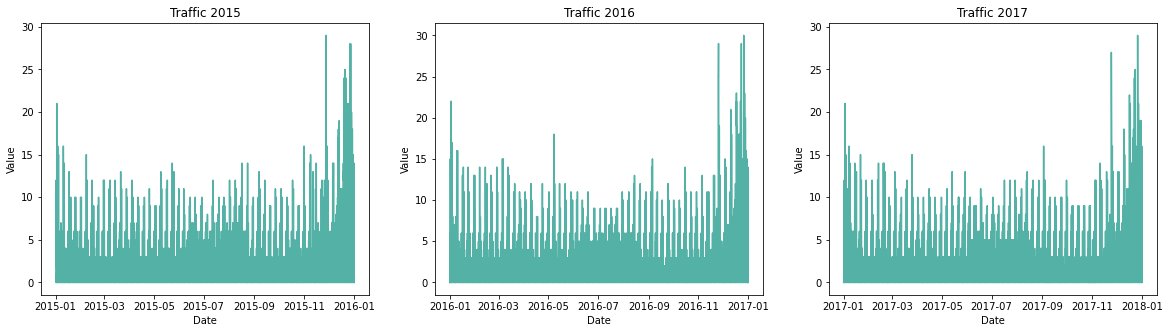

In [13]:
# Plot the traffic data to observe any trends
plot_traffic = complete_traffic.copy()
plot_traffic["Date"] = plot_traffic.index

fix, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

sns.lineplot(x="Date",y="Value", data = plot_traffic.loc["2015"], ax=ax[0], color='#53B1A6')
ax[0].set_title("Traffic 2015")

plot_traffic["Date"] = plot_traffic.index
sns.lineplot(x="Date",y="Value", data = plot_traffic.loc["2016"], ax=ax[1], color='#53B1A6')
ax[1].set_title("Traffic 2016")

plot_traffic["Date"] = complete_traffic.index
sns.lineplot(x="Date",y="Value", data = plot_traffic.loc["2017"], ax=ax[2], color='#53B1A6')
ax[2].set_title("Traffic 2017")


plt.show()

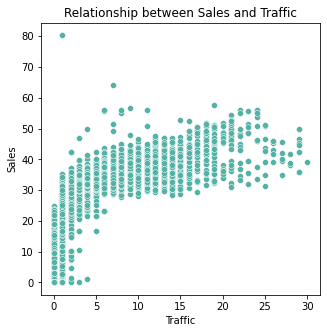

In [14]:
# Plot the relationship between the sales and traffic data
sales_r = complete_sales.loc["2015-01-01 10:00:00":]
traffic_r = complete_traffic.loc[:"2018-05-06 19:00:00"]

combined = pd.DataFrame(columns=["Sales","Traffic"])
combined["Traffic"]= traffic_r["Value"]
combined["Sales"] = sales_r["Value"]

plt.figure(figsize=(5,5))
sns.scatterplot(x='Traffic',y='Sales',data=combined, color = "#53B1A6")

plt.title("Relationship between Sales and Traffic")
plt.show()

## 4. Model Construction and Evaluation

In [15]:
# Ingest dataset containing public holidays
us_public_holidays = pd.read_csv("us_public_holidays.csv", parse_dates=["Date"],index_col="Date")
us_public_holidays.head()

,Holiday,WeekDay,Month,Day,Year
Date,,,,,
2004-07-04,4th of July,Sunday,7,4,2004
2005-07-04,4th of July,Monday,7,4,2005
2006-07-04,4th of July,Tuesday,7,4,2006
2007-07-04,4th of July,Wednesday,7,4,2007
2008-07-04,4th of July,Friday,7,4,2008


In [16]:
# Check for public holidays
def check_public_holidays(df):
    public_holidays = [] 

    for i in range(len(df)):
        if df.index[i].date() in us_public_holidays.index.date:
            public_holidays.append(1)
        else:
            public_holidays.append(0)
    return public_holidays

In [17]:
# Start with complete dataset
traffic_df = complete_traffic

# Feature Engineering - Extracting year, month, day and hour from the timestamp 
traffic_df["year"]= traffic_df.index.year
traffic_df["month"] = traffic_df.index.month
traffic_df["day"] = traffic_df.index.day
traffic_df["hour"] = traffic_df.index.hour

# Add public holiday feature
traffic_df["public_holiday"] = check_public_holidays(traffic_df)
traffic_df.head()

,Value,year,month,day,hour,public_holiday
Date,,,,,,
2015-01-01 10:00:00,2.0,2015,1,1,10,1
2015-01-01 11:00:00,3.0,2015,1,1,11,1
2015-01-01 12:00:00,7.0,2015,1,1,12,1
2015-01-01 13:00:00,8.0,2015,1,1,13,1
2015-01-01 14:00:00,11.0,2015,1,1,14,1


In [18]:
# Creating Dummy Variables for the year, month, day and hour variables 
traffic_df = pd.get_dummies(data=traffic_df, columns=['year','month','day','hour'])
traffic_df.head()

,Value,public_holiday,year_2015,year_2016,year_2017,year_2018,month_1,month_2,month_3,month_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 10:00:00,2.0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 11:00:00,3.0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 12:00:00,7.0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 13:00:00,8.0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 14:00:00,11.0,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [19]:
# Seperating out data into features and target variable  
X = traffic_df.drop("Value", axis=1).values
y = traffic_df["Value"].values

# Splitting Data into train, validation and test sets 
# 60% Training, 20% Validation, 20% Testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Scale data using Min Max Scaling 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define model architecture 
model = Sequential()

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

# Define model hyperparameters
model.compile(optimizer='adam',loss = 'mse')

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

Metal device set to: Apple M1


2022-04-18 21:49:34.172275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-18 21:49:34.172367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
# Fit model using training data
model.fit(x=X_train, y=y_train, 
          validation_data=(X_val,y_val),
          batch_size=256, verbose = 0,
          callbacks=[early_stop], epochs=1000)

2022-04-18 21:49:34.212266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-18 21:49:34.212447: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-18 21:49:34.330108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-18 21:49:34.679133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 00258: early stopping


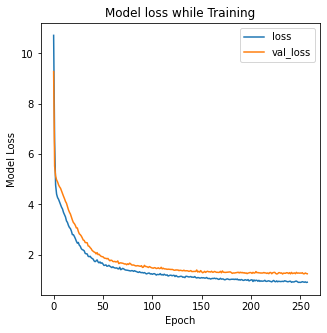

In [21]:
# Plot model loss during training
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(5,5))
plt.title("Model loss while Training")
plt.xlabel("Epoch")
plt.ylabel("Model Loss")
plt.show()

In [22]:
# Evaluate Model 
predictions = model.predict(X_test).flatten()
print("Root Mean Squared Error",np.sqrt(mean_squared_error(y_test,predictions)))
print("Mean Absolute Error",mean_absolute_error(y_test, predictions))
print("Explained Variance Score",explained_variance_score(y_test, predictions))

# We know that traffic needs to be a whole number though, 
# let us round our predictions to the nearest integer and revaluate our model
print("\nEvaluation after rounding")
predictions = np.round(predictions)
print("Root Mean Squared Error",np.sqrt(mean_squared_error(y_test,predictions)))
print("Mean Absolute Error",mean_absolute_error(y_test, predictions))
print("Explained Variance Score",explained_variance_score(y_test, predictions))

Root Mean Squared Error 1.0486227379016342
Mean Absolute Error 0.610561542919396
Explained Variance Score 0.8920982690822886

Evaluation after rounding
Root Mean Squared Error 1.069865032096637
Mean Absolute Error 0.5583219645293315
Explained Variance Score 0.8882895924634007


2022-04-18 21:50:41.669847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


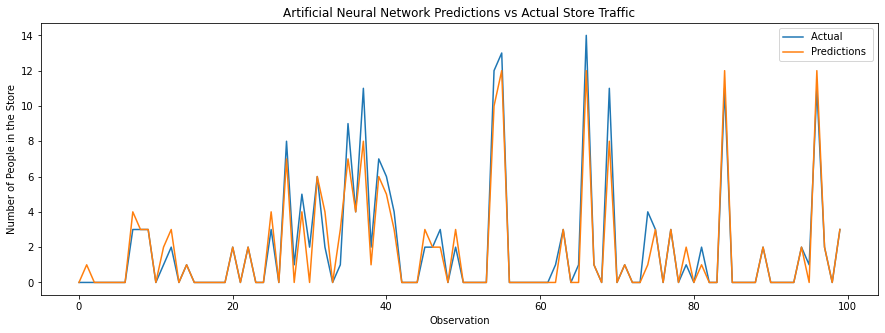

In [23]:
# Finally we can put our the results in a dataframe and plot it 
results = pd.DataFrame({"Actual":y_test, "Predictions": predictions})
plt.figure(figsize=(15,5))
plt.plot(results[0:100]["Actual"], label='Actual ')
plt.plot(results[0:100]["Predictions"], label='Predictions ')
plt.title("Artificial Neural Network Predictions vs Actual Store Traffic")
plt.ylabel("Number of People in the Store")
plt.xlabel("Observation")
plt.legend()
plt.show()

Now in order to forecast the next month we need to put the data in the correct input form for the model.

In [24]:
next_month_timestamps = []

start = complete_traffic.index[-1] + np.timedelta64(1,"h")
current = start
end = datetime.datetime(2018, 6, 6)

while current!=end:
    next_month_timestamps.append(current)
    current = current + np.timedelta64(1,"h")

In [25]:
next_month_df = pd.DataFrame(index=next_month_timestamps)

# Extract Necessary Features 
next_month_df["year"]= next_month_df.index.year
next_month_df["month"] = next_month_df.index.month
next_month_df["day"] = next_month_df.index.day
next_month_df["hour"] = next_month_df.index.hour

# Add public holiday feature
next_month_df["public_holiday"] = check_public_holidays(next_month_df)

In [26]:
# Get Dummy Variables for next months data and reindex it to have the same number of columns as the original data 
next_month_data = pd.get_dummies(data=next_month_df, columns=['year','month','day','hour'])
next_month_data = next_month_data.reindex(columns=traffic_df.columns, fill_value=0).drop("Value",axis=1).values

# Scale next months data
next_month_data = scaler.transform(next_month_data)

# Make predictions for next month
next_month_df["predicted traffic"] = np.round(np.abs(model.predict(next_month_data)))

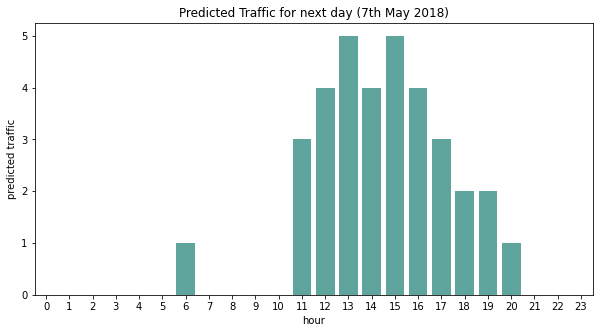

In [27]:
# Plot next days prediction
next_month_traffic = next_month_df.copy()
next_month_traffic["Date"] = next_month_df.index 
plt.figure(figsize=(10,5))
sns.barplot(x="hour",y="predicted traffic", data=next_month_traffic[0:24], color='#53B1A6')
plt.title("Predicted Traffic for next day (7th May 2018)")
plt.show()

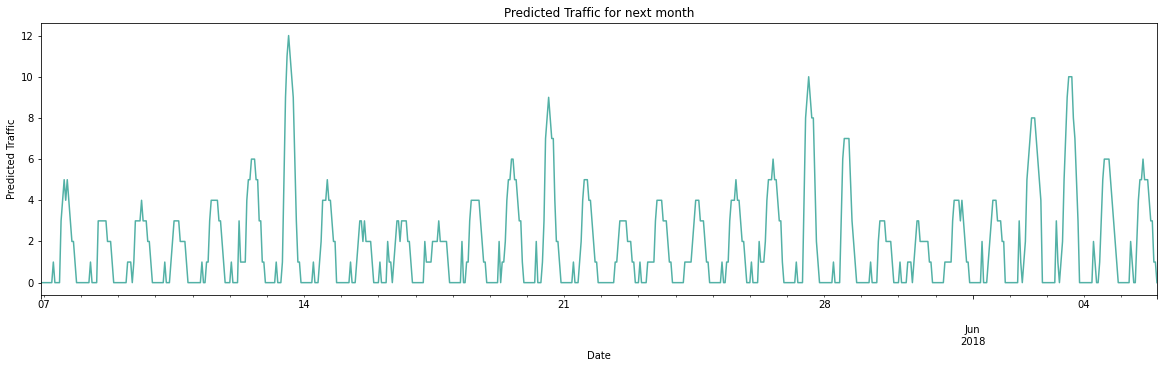

In [28]:
# Plot next months prediction
next_month_traffic = next_month_df.copy()
next_month_traffic["Date"] = next_month_df.index 
plt.figure(figsize=(20,5))
next_month_traffic["predicted traffic"].plot(color= "#53B1A6")
plt.title("Predicted Traffic for next month")
plt.xlabel("Date")
plt.ylabel("Predicted Traffic")
plt.show()

### Sales Model 

In [29]:
# Get sales and traffic data in same period 
sales_r = complete_sales.loc["2015-01-01 10:00:00":]
traffic_r = complete_traffic.loc[:"2018-05-06 19:00:00"]

# Create Data Frame to store sales data 
sales_df = pd.DataFrame(columns=["Sales","Traffic"])
sales_df["Traffic"]= traffic_r["Value"]
sales_df["Sales"] = sales_r["Value"]

# Feature Engineering - Extracting year, month, day and hour from the timestamp 
sales_df["year"]= sales_df.index.year
sales_df["month"] = sales_df.index.month
sales_df["day"] = sales_df.index.day
sales_df["hour"] = sales_df.index.hour

# Add public holiday feature
sales_df["public_holiday"] = check_public_holidays(sales_df)

# Creating Dummy Variables for the year, month, day and hour variables 
sales_df = pd.get_dummies(data=sales_df, columns=['year','month','day','hour'])

# Seperating out data into features and target variable  
X = sales_df.drop("Sales", axis=1).values
y = sales_df["Sales"].values

# Split data into train and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale data using Min Max Scaling 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
# Fit the model on the training data 
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

In [31]:
# Model evaluation  
predictions = lr.predict(X_test)
print("Mean Squared Error",np.sqrt(mean_squared_error(y_test,predictions)))
print("Mean Absolute Error",mean_absolute_error(y_test, predictions))
print("Explained Variance Score",explained_variance_score(y_test, predictions))

Mean Squared Error 4.784012236063031
Mean Absolute Error 3.2235021848731162
Explained Variance Score 0.8972660841226904


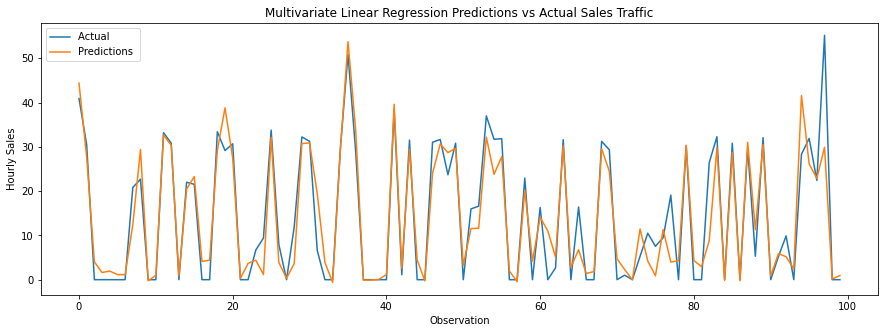

In [32]:
# Visualise Results
results = pd.DataFrame({"Actual":y_test, "Predictions": predictions})
plt.figure(figsize=(15,5))
plt.plot(results[0:100]["Actual"], label='Actual ')
plt.plot(results[0:100]["Predictions"], label='Predictions ')
plt.title("Multivariate Linear Regression Predictions vs Actual Sales Traffic")
plt.ylabel("Hourly Sales")
plt.xlabel("Observation")
plt.legend()
plt.show()

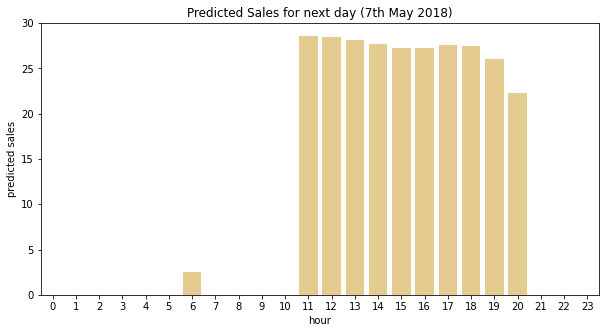

In [33]:
# Get Dummy Variables for next months data and reindex it to have the same number of columns as the original data 
next_month_data = pd.get_dummies(data=next_month_df, columns=['year','month','day','hour'])
next_month_data = next_month_data.reindex(columns=sales_df.columns, fill_value=0).drop("Traffic",axis=1).values

# Scale next months data
next_month_data = scaler.transform(next_month_data)

# Make Predictions 
next_month_df["predicted sales"] = lr.predict(next_month_data)

# Once again we know that if there is no traffic there will be no sales so we can include this prior knowledge 
next_month_df.loc[next_month_df["predicted traffic"]==0, "predicted sales"] =0 

# Visualise Predictions 
next_month_sales = next_month_df.copy()
next_month_sales["Date"] = next_month_df.index 
plt.figure(figsize=(10,5))
sns.barplot(x="hour",y="predicted sales", data=next_month_sales[0:24], color='#F2D282')
plt.title("Predicted Sales for next day (7th May 2018)")
plt.show()